# 1. Prelimitary

In [1]:
import numpy as np
import random
from project_utils import load_train_set, load_test_set, hint

random.seed()
np.random.seed()

TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

hint("Loading train set...")
train = load_train_set(TRAIN_PATH)

hint("Loading test set...")
test = load_test_set(TEST_PATH)

hint("Done!")

Done!


# 2. Preprocessing

In [2]:
from project_utils import standardize_images

IMAGE_DIM = (256, 256)

hint("Working on X...")
X = standardize_images(train['image'], shape=IMAGE_DIM)
hint("Working on Y...")
Y = standardize_images(train['mask'], shape=IMAGE_DIM, dtype=np.bool)
hint("Working on X_...")
X_ = standardize_images(test['image'], shape=IMAGE_DIM)

hint("Done!")

Done!


In [3]:
from project_utils import augment_data

X, Y = augment_data(X, Y, rotate=True, inverse_color=True)
print("%d samples added (total %d)" % (X.shape[0]-train.shape[0], X.shape[0]))

1340 samples added (total 2010)


# 3. Model

In [14]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam

CONV_KERNEL = (3, 3)
TRAN_KERNEL = (3, 3)
CONV_ACTIVATION = 'relu'
CONV_PADDING = 'same'
CONV_KERNEL_INIT = 'glorot_normal'
POOLING_SIZE = (2, 2)
OPTIMIZER = 'adam'

def build_conv_layer(filter_size):
    """
    build a convolution layer using the preset hyperparameters
    """
    return Conv2D(
        filter_size, 
        kernel_size=CONV_KERNEL,
        padding=CONV_PADDING,
        activation=CONV_ACTIVATION,
        kernel_initializer=CONV_KERNEL_INIT
    )

def build_conv_block(connect, depth, basesize, dropout):
    """
    build a 2-convolutional-layer block
    """
    filter_size = basesize*(2**depth)
    x = build_conv_layer(filter_size)(connect)
    if dropout > 0:
        x = Dropout(dropout)(x)
    x = build_conv_layer(filter_size)(x)
    return x

def build_upsample_block(connect, merge, depth, basesize):
    """
    build a upsampling block
    """
    filter_size = basesize*(2**depth)
    x = Conv2DTranspose(
        filter_size, 
        TRAN_KERNEL, 
        strides=POOLING_SIZE, 
        padding=CONV_PADDING
    )(connect)
    return concatenate([x, merge])

In [15]:
def get_model(basesize, dropout):
    np.random.seed(42)
    
    # input layer
    inputs = Input((IMAGE_DIM + (1,)))

    # downsampling layers (left of the U)
    down_conv_0 = build_conv_block(inputs, 0, basesize, dropout)
    down_pool_0 = MaxPooling2D(POOLING_SIZE)(down_conv_0)
    down_conv_1 = build_conv_block(down_pool_0, 1, basesize, dropout)
    down_pool_1 = MaxPooling2D(POOLING_SIZE)(down_conv_1)
    down_conv_2 = build_conv_block(down_pool_1, 2, basesize, dropout)
    down_pool_2 = MaxPooling2D(POOLING_SIZE)(down_conv_2)
    down_conv_3 = build_conv_block(down_pool_2, 3, basesize, dropout)
    down_pool_3 = MaxPooling2D(POOLING_SIZE)(down_conv_3)

    # bottom layer
    conv_bottom = build_conv_block(down_pool_3, 4, basesize, dropout)

    # upsampling layers (right of the U)
    upsample_3 = build_upsample_block(conv_bottom, down_conv_3, 3, basesize)
    up_conv_3 = build_conv_block(upsample_3, 3, basesize, dropout)
    upsample_2= build_upsample_block(up_conv_3, down_conv_2, 2, basesize)
    up_conv_2= build_conv_block(upsample_2, 2, basesize, dropout)
    upsample_1= build_upsample_block(up_conv_2, down_conv_1, 1, basesize)
    up_conv_1= build_conv_block(upsample_1, 1, basesize, dropout)
    upsample_0= build_upsample_block(up_conv_1, down_conv_0, 0, basesize)
    up_conv_0= build_conv_block(upsample_0, 0, basesize, dropout)

    # output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_0)

    # compile
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=OPTIMIZER, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

test_hypers = [
    (16, 0),
    (32, 0),
    (16, 0,2),
    (32, 0.2),
]

labels = [
    "dropout-, basesize-",
    "dropout-, basesize+",
    "dropout+, basesize-",
    "dropout+, basesize+",
]

In [16]:
from keras.models import load_model
from sklearn.model_selection import train_test_split

BATCH_SIZE = 16
EPOCHS = 40
VALIDATION_SIZE = 0.1

Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=VALIDATION_SIZE)

history = []
for i, (label, th) in enumerate(zip(labels, test_hypers)):
    hint("Working on model %d/%d (%s)" % (i+1, len(test_hypers), label))
    history.append(get_model(th[0], th[1]).fit(
        Xtr, Ytr, 
        validation_data=(Xva, Yva),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        verbose=2
    ))

Working on model 2/4 (dropout-, basesize+)
Train on 1809 samples, validate on 201 samples
Epoch 1/40
 - 88s - loss: 2.0074 - acc: 0.8422 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 2/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 3/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 4/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 5/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 6/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 7/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 8/40
 - 81s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 9/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 10/40
 - 82s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - val_acc: 0.8476
Epoch 11/40
 - 81s - loss: 2.4371 - acc: 0.8488 - val_loss: 2.4561 - 

KeyboardInterrupt: 

# 4. Conclusion

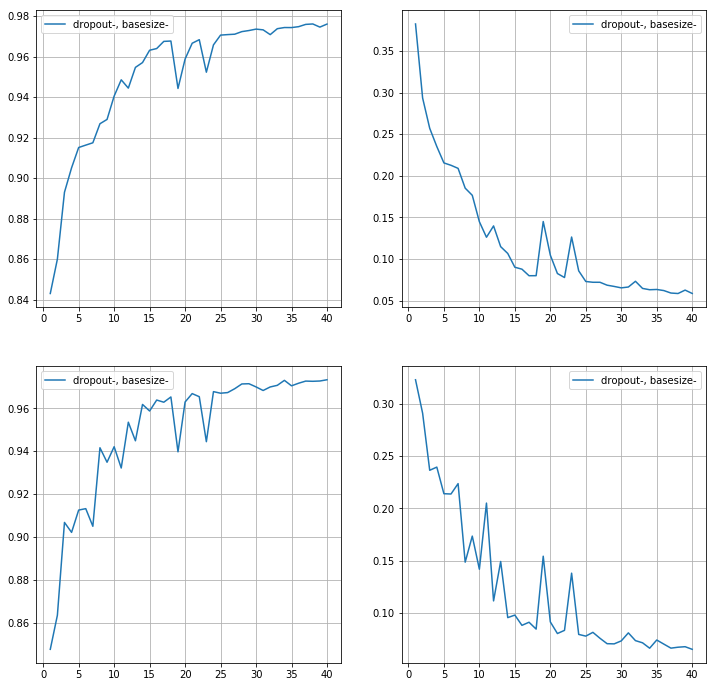

In [18]:
import matplotlib.pyplot as plt

_, axis = plt.subplots(2, 2, figsize=(12, 12))
x_axis = range(1, EPOCHS+1)
for h, l in zip(history, labels):
    axis[0, 0].plot(x_axis, h.history['acc'], label=l)
    axis[0, 1].plot(x_axis, h.history['loss'], label=l)
    axis[1, 0].plot(x_axis, h.history['val_acc'], label=l)
    axis[1, 1].plot(x_axis, h.history['val_loss'], label=l)
for r in range(2):
    for c in range(2):
        axis[r, c].legend()
        axis[r, c].grid(True)
plt.show()